In [1]:
import numpy as np
import matplotlib.pyplot as plt

## User class

In [2]:
class UserClass:
    """
    F1 and F2: in {0,1}
        are the binary features
    v: positive number
        is the value per click
    click_function: it is a function
        represents the number of clicks given a bid
    cost_function: it is a function
        represents the cost given a bid
    conversion_rate: a function with image in [0,1] (com: usually descendent)
        it represent how a user is likely to buy the product given a price
        Obs:
        |   in the text says to consider just 5 prices, maybe we can consider this as an array instead of a function
        |__

    """

    def __init__(self, F1, F2, v, click_function, cost_function, conversion_rate_function):
        self.v = v
        self.F1 = F1
        self.F2 = F2
        self.click_function = click_function
        self.cost_function = cost_function
        self.conversion_rate_function = conversion_rate_function



## Step 1

-we are just considering one class of users
<br>
-n and c are known
\
-alpha is unknown

### Environment

In [3]:
class Environment:

    def __init__(self, n_arms, prices, user_class):
        """
        n_arms: integer

        prices: array
            it is the set of prices we will use, since we are discretizing the problem
            eg: an array of 5
        """
        self.n_arms = n_arms
        self.prices = prices
        self.user_class = user_class


        self.convertion_probabilities = [user_class.conversion_rate_function(p) for p in prices]


    def round(self, n_daily_clicks, margin, cum_daily_costs, pulled_arm_price):
        #OBS:
        # The conversion probability is the probability of buying the item given a price, thus is a Bernoulli probabilty

        alpha = self.convertion_probabilities[pulled_arm_price]
        #here sampled reward
        reward = np.random.binomial(n_daily_clicks, alpha) * margin - cum_daily_costs
        # if reward in expextation: reward = n_daily_clicks * alpha * margin - cum_daily_costs

        return reward

### Learners

Obs: here the arms are for the prices

In [4]:
import numpy as np

class Learner:
    """
    Atributes:
    (....)
    rewards_per_arm: a list of list of dimension: number_of_arms x self.t

    (....)
    """

    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.t = 0 #current round
        self.rewards_per_arm = x = [[] for i in range(n_arms)]
        self.collected_rewards = np.array([])

    def pull_arm(self):
        pass

    def update_observations(self, pulled_arm, reward):
        self.rewards_per_arm[pulled_arm].append(reward)
        self.collected_rewards = np.append(self.collected_rewards, reward)



In [5]:
# from Learner import *

class Binomial_TS_Learner(Learner):
    """
    prior: P(p) as Beta(alpha, beta)
    likelihood: p(k|p;n) =  Binomial(n,p)

    By Bayes, we have that:
        posterior: p(p|k;n) = Beta(alpha+k, beta+k-n)


    Note:
        - This algorithm learns p assuming n is known (n is the maximum value k can assume)
        - In this simple scenario thr reward we observe is k
    """

    def __init__(self, n_arms, n):
        super().__init__(n_arms)
        self.beta_parameters = np.ones((n_arms, 2))
        self.n = n


    def pull_arm(self):
        idx = np.argmax(np.random.beta( self.beta_parameters[:,0], self.beta_parameters[:,1] ))
        return idx

    def update(self, pulled_arm, reward):
        self.t += 1
        self.update_observations(pulled_arm, reward)

        self.beta_parameters[pulled_arm,0] = self.beta_parameters[pulled_arm,0] + reward
        self.beta_parameters[pulled_arm,1] = self.beta_parameters[pulled_arm,1] + self.n - reward



class Custom_TS_Learner(Binomial_TS_Learner):
    def __init__(self, n_arms, n):
        super().__init__(n_arms, n)


    # def from_reward_to_k(reward, cost, margin):
    #     k = (reward + cost)/margin
    #     return k

    def update(self, pulled_arm, reward, cost, margin):
        self.t += 1
        self.update_observations(pulled_arm, reward)

        k = (reward + cost) / margin#self.from_reward_to_k(cost,margin)
        self.beta_parameters[pulled_arm,0] = self.beta_parameters[pulled_arm,0] + k
        self.beta_parameters[pulled_arm,1] = self.beta_parameters[pulled_arm,1] + self.n - k



In [6]:
class UCB1_Learner(Learner):

    def __init__(self, n_arms):
        super().__init__(n_arms)
        self.empirical_means = np.ones(n_arms)
        self.confidence = np.full(n_arms, np.inf)


    def pull_arm(self):
        upper_confidence = self.empirical_means + self.confidence
        idx = np.random.choice(np.where(upper_confidence == upper_confidence.max())[0])
        return idx

    def update(self, pulled_arm, reward):
        self.t += 1
        self.empirical_means[pulled_arm] = ((self.t - 1) * self.empirical_means[pulled_arm] + reward) / self.t

        for a in range(self.n_arms):
            n_samples = len(self.rewards_per_arm[a])

            if n_samples > 0:
                c = np.sqrt(2)
                self.confidence[a] = c * np.sqrt(np.log(self.t)/n_samples)

        self.update_observations(pulled_arm, reward)


class Custom_UCB_Learner(UCB1_Learner):

    def __init__(self, n_arms, n):#n = number of clicks
        super().__init__(n_arms)
        self.n = n


    def update(self, pulled_arm, reward, cost, margin):
        self.t += 1
        self.empirical_means[pulled_arm] = ((self.t - 1) * self.empirical_means[pulled_arm] + reward) / self.t

        for a in range(self.n_arms):
            n_samples = len(self.rewards_per_arm[a])

            if n_samples > 0:
                c = self.n * np.sqrt(2)
                self.confidence[a] = c * np.sqrt(np.log(self.t)/n_samples) * margin - cost

        self.update_observations(pulled_arm, reward)

### Example

In [7]:
F1 = 0
F2 = 0
v = 3
def click_f(bid):
    bid_0 = 2
    bid_1 = 6
    max_clicks = 5

    # if bid < bid_0:
    #     return 0
    # elif bid < bid_1:
    #     return n_max * (bid - bid_0)/(bid_1-bid_0)
    # return n_max


    return (bid < bid_1) * (bid > bid_0) * (bid - bid_0)/(bid_1-bid_0) * max_clicks + (bid >= bid_1) * max_clicks



def cost_f(bid):
    return bid * 2

def conversion_rate_f(price):
    return np.exp(-price)

def conversion_rate_f(price):
    return np.exp(-price)

C1 = UserClass(F1, F2, v, click_f, cost_f, conversion_rate_f)

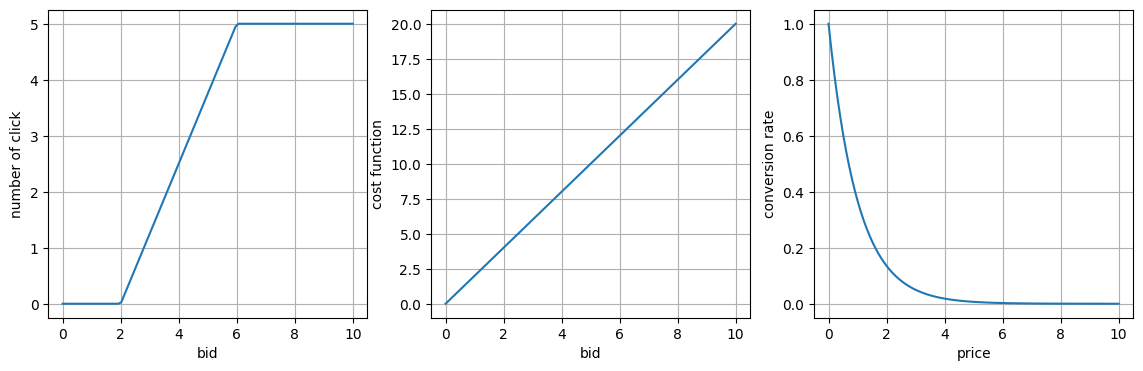

In [8]:
plt.figure(figsize=(14,4))

xx = np.linspace(0,10,100)
plt.subplot(1,3,1)
plt.plot(xx, click_f(xx))
plt.xlabel('bid')
plt.ylabel('number of click')
plt.grid(True)

xx = np.linspace(0,10,100)
plt.subplot(1,3,2)
plt.plot(xx, cost_f(xx))
plt.xlabel('bid')
plt.ylabel('cost function')
plt.grid(True)

xx = np.linspace(0,10,100)
plt.subplot(1,3,3)
plt.plot(xx, conversion_rate_f(xx))
plt.xlabel('price')
plt.ylabel('conversion rate')
plt.grid(True)

In [64]:
#Fixed parameters
n_arms = 5
T = 365

# in this step n_clicks and cost are given
# so let's fix a bid and compute n_clicks and cost
BID = 6
n_daily_clicks = C1.click_function(BID)
cum_daily_costs = C1.cost_function(BID)

margin = 90


#setting the arms
prices = np.array([1,3,5,7,9])
opt_arm = np.argmax(C1.conversion_rate_function(prices)) #optimal value of convertion rate between the arms
opt = n_daily_clicks * C1.conversion_rate_function(prices[opt_arm]) * margin - cum_daily_costs

UCB

In [66]:
## UCB learner

n_experiments = 1000
ucb_rewards_per_experiment = []

for e in range(0, n_experiments):
    # print(f'{e/n_experiments*100}%')

    env = Environment(n_arms, prices, C1)
    ucb_learner = Custom_UCB_Learner(n_arms,n_daily_clicks)

    rewards_single_experiment = []
    for t in range(0, T):
        pulled_arm = ucb_learner.pull_arm()
        reward = env.round(n_daily_clicks, margin, cum_daily_costs, pulled_arm)
        ucb_learner.update(pulled_arm, reward,cum_daily_costs, margin)

        rewards_single_experiment.append(reward)

    ucb_rewards_per_experiment.append(rewards_single_experiment)

In [ ]:
# #Plots
# plt.figure(figsize = (14,4))

# plt.subplot(1,2,1)
# plt.xlabel("t")
# plt.ylabel("rewards")
# plt.plot(np.arange(T), np.full(T,opt))
# plt.plot(np.mean(ucb_rewards_per_experiment, axis = 0), 'r')
# plt.legend(["optimal","UCB"])

# plt.subplot(1,2,2)
# plt.xlabel("t")
# plt.ylabel("cumulative regret")
# plt.plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment, axis = 0)), 'r')
# plt.legend(["UCB"])

Thompson sampling

In [68]:
## TS learner

n_experiments = 1000
ts_rewards_per_experiment = []

for e in range(0, n_experiments):
    # print(f'{e/n_experiments*100}%')

    env = Environment(n_arms, prices, C1)
    ts_learner = Custom_TS_Learner(n_arms,n_daily_clicks)

    rewards_single_experiment = []
    for t in range(0, T):
        pulled_arm = ts_learner.pull_arm()
        reward = env.round(n_daily_clicks, margin, cum_daily_costs, pulled_arm)
        ts_learner.update(pulled_arm, reward,cum_daily_costs, margin)

        rewards_single_experiment.append(reward)

    ts_rewards_per_experiment.append(rewards_single_experiment)

In [ ]:
# #Plots
# plt.figure(figsize = (14,4))

# plt.subplot(1,2,1)
# plt.xlabel("t")
# plt.ylabel("rewards")
# plt.plot(np.arange(T), np.full(T,opt))
# plt.plot(np.mean(ts_rewards_per_experiment, axis = 0), 'r')
# plt.legend(["optimal","TS"])

# plt.subplot(1,2,2)
# plt.xlabel("t")
# plt.ylabel("regret")
# plt.plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment, axis = 0)), 'r')
# plt.legend(["TS"])

Plots both methods

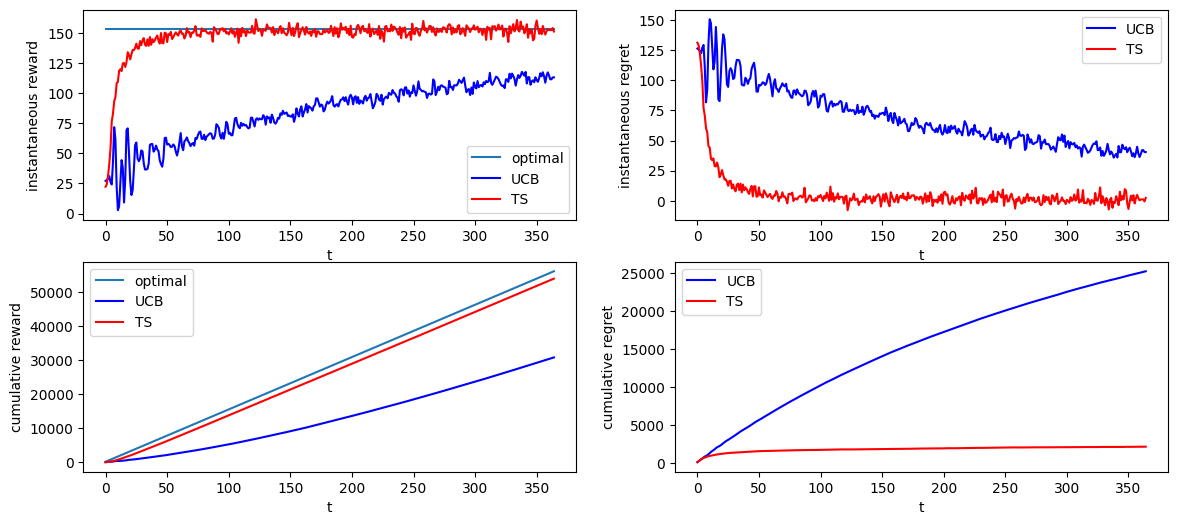

In [75]:
#Plots
plt.figure(figsize = (14,6))

plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt))
plt.plot(np.mean(ucb_rewards_per_experiment, axis = 0), 'b')
plt.plot(np.mean(ts_rewards_per_experiment, axis = 0), 'r')
plt.legend(["optimal","UCB","TS"])

plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(np.mean(opt - ucb_rewards_per_experiment, axis = 0), 'b')
plt.plot(np.mean(opt - ts_rewards_per_experiment, axis = 0), 'r')
plt.legend(["UCB","TS"])



plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)))
plt.plot(np.cumsum(np.mean(ucb_rewards_per_experiment, axis = 0)), 'b')
plt.plot(np.cumsum(np.mean(ts_rewards_per_experiment, axis = 0)), 'r')
plt.legend(["optimal","UCB","TS"])

plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment, axis = 0)), 'b')
plt.plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment, axis = 0)), 'r')
plt.legend(["UCB","TS"])

## Step 2

## Step 3

## Step 4

## Step 5

## Step 6